In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import numpy as np
import pointprocesses as ppr

In [3]:
import torch
from torch import nn

In [4]:
torch.manual_seed(1)

In [5]:
import os
import sys
import tqdm

In [6]:
# Add parent dir to interpreter path
nb_dir = os.path.split(os.getcwd())[0]
print("Notebook dir {:}".format(nb_dir))
if nb_dir not in sys.path:
    sys.path.append(nb_dir)

Notebook dir /home/manifold/Documents/etudes/map511-p3a


In [7]:
for path in sys.path:
    print(path)


/home/manifold/Documents/etudes/map511-p3a/notebooks
/home/manifold/miniconda3/envs/pytorch/lib/python37.zip
/home/manifold/miniconda3/envs/pytorch/lib/python3.7
/home/manifold/miniconda3/envs/pytorch/lib/python3.7/lib-dynload
/home/manifold/miniconda3/envs/pytorch/lib/python3.7/site-packages
/home/manifold/miniconda3/envs/pytorch/lib/python3.7/site-packages/pointprocesses-0.4.1-py3.7-linux-x86_64.egg
/home/manifold/miniconda3/envs/pytorch/lib/python3.7/site-packages/torchvision-0.2.1-py3.7.egg
/home/manifold/miniconda3/envs/pytorch/lib/python3.7/site-packages/IPython/extensions
/home/manifold/.ipython
/home/manifold/Documents/etudes/map511-p3a


# Synthetic data, Hawkes processes

The standard Hawkes model has an underlying intensity given by
$$
    \lambda_t = \lambda^0_t + \int_0^t g(t-s)\,dN_s
$$
where the function $g \geq 0$ is called the _kernel_.

Here we simulate Hawkes processes with kernel $g(t) = \alpha\exp(-\delta t)$.

In [8]:
def intensity_function_(t, lam0, alpha, beta, history):
    return lam0 + np.sum(alpha*beta*np.exp(-beta*(t - history))*(t >= history), axis=0)

intensity_function = np.vectorize(intensity_function_, excluded={4})

In [9]:
import itertools
mu = 1.0
tmax = 60.0
alpha = 0.2
beta  = 5
avg_num_of_events = tmax*mu/(1.-alpha/beta)
print("Expected avg evt no. %.3f" % avg_num_of_events)

Expected avg evt no. 62.500


In [10]:
n_traj = 1000
sample_trajectories = [
    torch.from_numpy(ppr.hawkes_exp(tmax, beta, mu, itertools.repeat(alpha)))
    for _ in range(n_traj)
]

print("Number of samples: \t\t%d" % len(sample_trajectories))
seq_lengths = torch.LongTensor([s.shape[0] for s in sample_trajectories])
input_size = seq_lengths.max().item()
print("Input size max. traj. length: \t%d" % input_size)
print("tmax = %.3f"  % tmax)
print("Empirical average %.3f" % seq_lengths.to(torch.float).mean().item())

data_tensor = nn.utils.rnn.pad_sequence(sample_trajectories).to(torch.float)
# Sort the sequences by decreasing length
seq_lengths, order_index_ = seq_lengths.sort(descending=True) # first sort the tensor of lengths
data_tensor = data_tensor[:, order_index_, :]
# Extract only times, append a beginning of sequence event
times_tensor = data_tensor[:,:,0]
# times_tensor = torch.cat((torch.zeros(1,times_tensor.shape[1]), times_tensor), dim=0)
# seq_lengths += 1

Number of samples: 		1000
Input size max. traj. length: 	90
tmax = 60.000
Empirical average 62.413


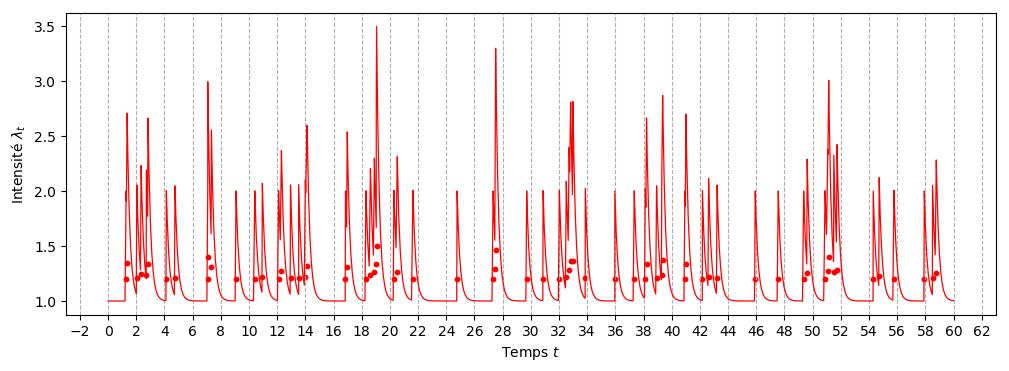

In [11]:
one_traj = sample_trajectories[1].numpy()
fig, ax = plt.subplots(1,1, figsize=(12,4), dpi=100)
ax.set_xlabel("Temps $t$")
ax.set_ylabel(r"Intensité $\lambda_t$")
t_arr = np.sort(np.append(np.linspace(0, tmax, 600), one_traj[:,0]))
ax.plot(t_arr, intensity_function(t_arr, mu, alpha, beta, one_traj[:,0]), 'r-', linewidth=0.9)
ax.xaxis.set_major_locator(mticker.MultipleLocator(2.))
scatter_opts = {
    "c": "r", "s": 11
}
ax.grid(True, axis='x', linestyle='--')
ax.scatter(one_traj[:,0], one_traj[:,1], c='r', s=10)

We will pad each sequence with 0s at the end.

Text(0, 0.5, 'Number')

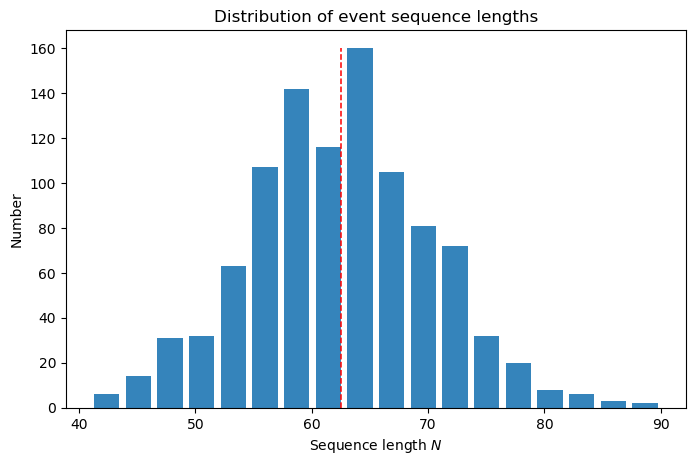

In [12]:
fig, ax = plt.subplots(1, 1, figsize=(8,5), dpi=100)
arr, bins, patches = ax.hist(seq_lengths,
                             bins=2*int(seq_lengths.size(0)**(1/3)),
                             rwidth=0.8, alpha=0.9)
ax.set_title('Distribution of event sequence lengths')
ax.vlines(avg_num_of_events, 0., arr.max(),
          linestyles="--", linewidth=1.1, color="r")
ax.set_xlabel('Sequence length $N$')
ax.set_ylabel('Number')

In [13]:
data_tensor.shape

torch.Size([90, 1000, 3])

Save the tensor down to a file

In [15]:
import pickle
filepath = "../data/simulated/hawkes_sim_tensor_save.pkl"
with open(filepath, "wb") as f:
    save_data_ = {
        "mu": mu,
        "alpha": alpha,
        "decay": beta,
        "tmax": tmax,
        "data": data_tensor,
        "lengths": seq_lengths
    }
    pickle.dump(save_data_, f)

The first dimension is for the sequence length, the second for the sample number.

# Neural network

We are going for a recurrent neural structure that can learn from previous events. The intensity process of our neural model will be of the form

$$
    \lambda_t = \phi\left(W_{\lambda} h(t)\right)
$$

with $\phi$ a positive-valued activation function (such as ReLU) and $h(t)\in\mathbb R^D$ a continuous hidden state, computed as
\begin{equation}
    h(t) = h_{i-1}e^{-\delta_i(t-t_{i-1})},\quad \forall t\in(t_{i-1},t_i]
\end{equation}

Network update formulas: the jump and decay parameters on $(t_i,t_{i+1}]$ are given by
$$
\begin{align*}
    h_{i+1}      &= \tanh(W_{hh}h(t_i) + b_{hh} + W_{ih}k_i + b_{ih}) \\
    \delta_{i+1} &= \sigma(W_d h(t_i) + b_d)
\end{align*}
$$

In [27]:
from torch import nn
import torch.nn.functional as F

In [83]:
from models.decayrnn import HawkesDecayRNN

In [84]:
hidden_size = 16
model = HawkesDecayRNN(hidden_size)
optimizer = torch.optim.Adagrad(model.parameters(), lr=0.007)

In [85]:
def train(model: HawkesDecayRNN, sequence: torch.Tensor, seq_lengths: torch.Tensor):
    """
    Args:
        model: recurrent neural net model
        sequence: event sequence
        seq_lengths: sequence length
    """
    max_seq_length = seq_lengths[0]
    sequence = sequence[:max_seq_length]
    # Embed the sequence into the event arrival intervals
    sequence = torch.cat((torch.zeros_like(sequence[:1]), sequence))
    dt_sequence = sequence[1:] - sequence[:-1]
    # Trim the sequence to its real length
    packed_seq = nn.utils.rnn.pack_padded_sequence(dt_sequence, seq_lengths)
    # Reshape to a format the RNN can understand
    # N * batch
    max_batch_size = packed_seq.batch_sizes[0]
    # Data records
    # hidd_decayed: 0
    # decay: 0
    hidd_decayed, decay = model.initialize_hidden(max_batch_size)
    hiddens = []
    decays = []
    for i in range(max_seq_length):
        # event t_i is happening
        batch_size = packed_seq.batch_sizes[i]
        # hidden state just before this event
        hidd_decayed = hidd_decayed[:batch_size]
        # time until next event t_{i+1}
        dt_batch = dt_sequence[i, :batch_size]
        hidd, decay, hidd_decayed = model(dt_batch.unsqueeze(1), hidd_decayed)
        hiddens.append(hidd)
        decays.append(decay)
    train_data = {
        "hidden": hiddens,
        "decay": decays
    }
    loss: Tensor = model.compute_loss(sequence.unsqueeze(2), packed_seq.batch_sizes, hiddens, decays, tmax)
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()  # zero the gradients
    return train_data, loss.item()

In [86]:
# define training loop
train_size = int(0.75*times_tensor.size(1))
EPOCHS = 50
BATCH_SIZE = 20
print("Train size %d" % train_size)

Train size 750


In [87]:
loss_hist = []
for e in range(1, EPOCHS+1):
    # Epoch loop
    tr_loop_range = tqdm.tqdm_notebook(range(0, train_size, BATCH_SIZE), file=sys.stdout, desc="Epoch %d" % e)
    for i in tr_loop_range:
        sequence = times_tensor[:, i:(i+BATCH_SIZE)]
        train_info, loss = train(model, sequence, seq_lengths[i:(i+BATCH_SIZE)])
    loss_hist.append(loss)  # append the final loss of each epoch

Exception ignored in: <function tqdm.__del__ at 0x7f51778508c8>
Traceback (most recent call last):
  File "/home/manifold/miniconda3/envs/pytorch/lib/python3.7/site-packages/tqdm/_tqdm.py", line 931, in __del__
    self.close()
  File "/home/manifold/miniconda3/envs/pytorch/lib/python3.7/site-packages/tqdm/_tqdm.py", line 1133, in close
    self._decr_instances(self)
  File "/home/manifold/miniconda3/envs/pytorch/lib/python3.7/site-packages/tqdm/_tqdm.py", line 496, in _decr_instances
    cls.monitor.exit()
  File "/home/manifold/miniconda3/envs/pytorch/lib/python3.7/site-packages/tqdm/_monitor.py", line 52, in exit
    self.join()
  File "/home/manifold/miniconda3/envs/pytorch/lib/python3.7/threading.py", line 1029, in join
    raise RuntimeError("cannot join current thread")
RuntimeError: cannot join current thread


Text(0, 0.5, 'Loss')

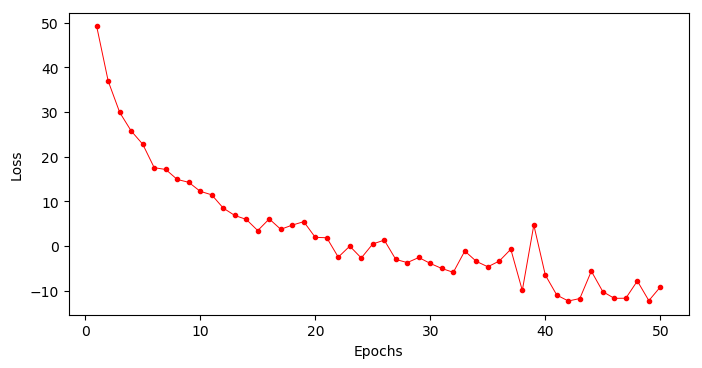

In [88]:
fig, ax = plt.subplots(1,1, figsize=(8,4), dpi=100)
epochs_range = list(range(1, EPOCHS+1))
ax.plot(epochs_range, loss_hist, color='red',
         linewidth=.7, marker='.')
ax.set_xlabel("Epochs")
ax.set_ylabel("Loss")

In [240]:
# Build a statistic for the no. of events
gen_seq_lengths = []
n_gen_seq = 1000 # number of generated sequences
for i in range(n_gen_seq):
    gen_event_times, gen_event_intens, gen_event_decay = model.generate_sequence(tmax)
    gen_seq_lengths.append(len(gen_event_times) - 1)

In [241]:
n_gen_seq

1000

In [242]:
MODEL_NAME = "Decay-RNN"

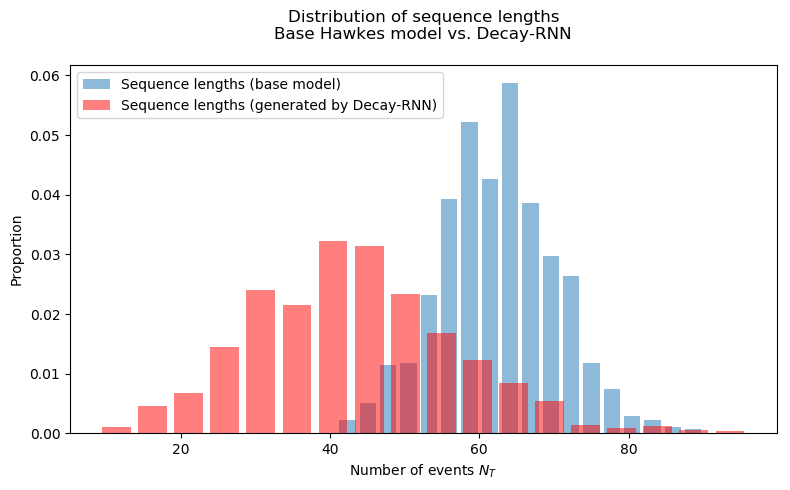

In [243]:
fig, ax = plt.subplots(1, 1, figsize=(8,5), dpi=100)
_ = ax.hist(seq_lengths, bins=2*int(seq_lengths.size(0)**(1/3)),
            label="Sequence lengths (base model)",
            rwidth=0.8, alpha=0.5, density=True)
_ = ax.hist(gen_seq_lengths, bins=2*int(n_gen_seq**(1/3)),
            label="Sequence lengths (generated by {:})".format(MODEL_NAME),
            rwidth=0.8, alpha=0.5, color='red', density=True)
ax.legend()
ax.set_ylabel('Proportion')
ax.set_xlabel('Number of events $N_T$')
ax.set_title("""Distribution of sequence lengths
Base Hawkes model vs. {:}
""".format(MODEL_NAME))
fig.tight_layout()

In [244]:
RESULT_BASEDIR = "../results"
os.makedirs(RESULT_BASEDIR, exist_ok=True)
model_perf_indicator = "seq_length_distrib"
fig.savefig("{:}/{:}.{:}.pdf".format(RESULT_BASEDIR, model_perf_indicator, MODEL_NAME))

The number of events does not fit.

In [245]:
def plot_events_and_intensity(event_times, hidden_states, event_decay):
    fig, (ax0, ax1) = plt.subplots(2, 1, sharex=True,
                                   dpi=120,
                                   gridspec_kw = {'height_ratios':[3, 0.3]},
                                   figsize=(10,6))
    time_arr = np.linspace(0, tmax, 1000)
    n_events = event_times.shape[0] - 1
    max_intens = max(e.max() for e in hidden_states)
    min_intens = min(e.min() for e in hidden_states)
    y_intens = []
    curr_index = 0
    for ti in time_arr:
        if curr_index < len(hidden_states)-1 and ti > event_times[curr_index+1]:
            curr_index += 1
        hi = hidden_states[curr_index]
        li = model.intensity_activ(model.intensity_layer(hi)).detach().numpy()
        dec = event_decay[curr_index].numpy()
        t_incr = ti - event_times[curr_index]  # >= 0 by construction
        y_intens.append(li*np.exp(-dec*t_incr))
    event_intens = [model.intensity_activ(model.intensity_layer(h)).item()
                    for h in hidden_states]
    ax0.scatter(event_times[1:], event_intens,
                facecolor='k',
                s=6, alpha=0.7)
    ax0.set_ylabel("Event intensities $\lambda_t$")
    ax0.plot(time_arr, y_intens, color='r',
             linewidth=.7, linestyle='--')
    ax1.scatter(event_times[1:], np.random.rand(n_events),
                alpha=0.4, s=16)
    ax1.set_ylim((-0.3,1.3))
    ax1.set_xlabel("Time $t$")

tensor([[0.2310]])
tensor([[1.4269]])
tensor([[6.2262]])
tensor([[25.7053]])
tensor([[100.6508]])
tensor([[42.3601]])
tensor([[11.7187]])
tensor([[0.2331]])
tensor([[1.4269]])
tensor([[5.4859]])
tensor([[2.9263]])
tensor([[0.4568]])
tensor([[0.2626]])
tensor([[1.4269]])
tensor([[1.0640]])
tensor([[2.5773]])
tensor([[11.2014]])
tensor([[2.0142]])
tensor([[0.9088]])
tensor([[1.4316]])
tensor([[5.6134]])
tensor([[11.3831]])
tensor([[26.6445]])
tensor([[57.4842]])
tensor([[131.7721]])
tensor([[24.5589]])
tensor([[94.0102]])
tensor([[16.1395]])
tensor([[0.9484]])
tensor([[0.2310]])
tensor([[1.4269]])
tensor([[6.0092]])
tensor([[27.6070]])
tensor([[7.7773]])
tensor([[0.8385]])
tensor([[0.2310]])
tensor([[1.4269]])
tensor([[5.4483]])
tensor([[13.6405]])
tensor([[6.7333]])
tensor([[0.2865]])
tensor([[1.4269]])
tensor([[4.9483]])
tensor([[17.0816]])
tensor([[2.4841]])
tensor([[0.5985]])
tensor([[0.2314]])
tensor([[1.4269]])
tensor([[0.7650]])
tensor([[0.3363]])
tensor([[0.2439]])
tensor([[1.487

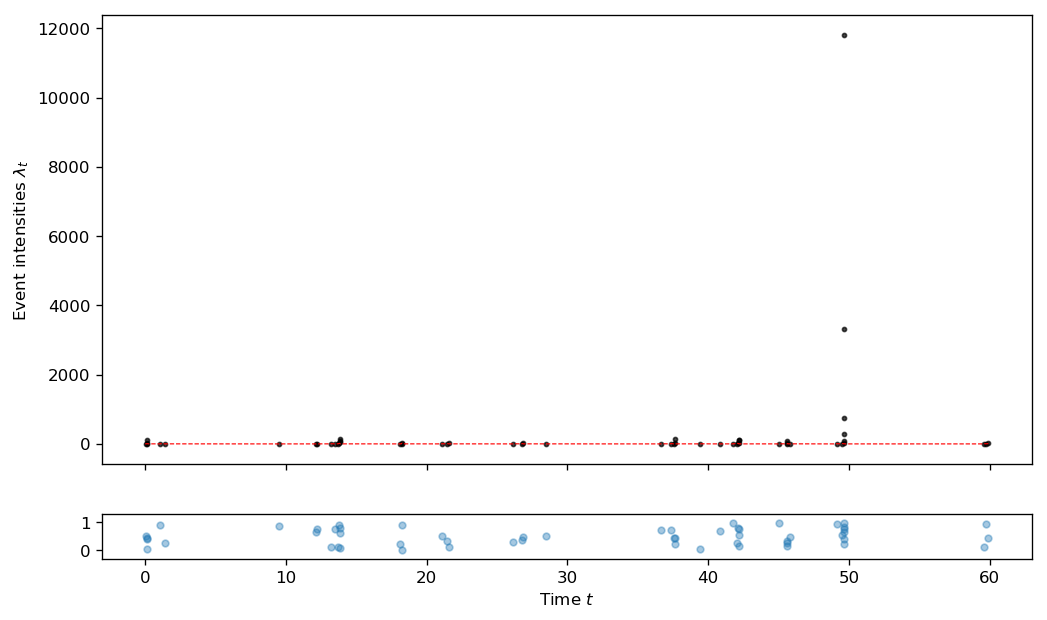

In [265]:
gen_event_times, gen_event_intens, gen_event_decay = model.generate_sequence(tmax)
plot_events_and_intensity(gen_event_times, gen_event_intens, gen_event_decay)